In [307]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display as ipd
from ipynb.fs.defs.utility import *
from dataclasses import dataclass

In [462]:
# min frequency of each oscillator
VCO_F_MIN, VCO_F_MAX = 40, 20000
LFO_F_MIN, LFO_F_MAX = 1/60, 1000

WAVE_SIN, WAVE_TRI, WAVE_SQR, WAVE_SAW  = 0, 1, 2, 3 # wavetable shape indices
NUM_WAVES = 4

weight = []

In [530]:
class Wavetable:

    def __init__(self, table_size, num_waves, max_harmonics=1024, harmonic_derating=1):
        
        self.table_size = table_size
        self.num_waves = num_waves

        t = np.linspace(0, 1, table_size, endpoint=False)
        x = 2*np.pi*t
        
        
        # specifies max frequency of each wavetable
        boundaries = [20 * 2**i for i in range(11)]
        boundaries.extend([1.5*b for b in boundaries])
        boundaries.sort()
        self.boundaries = boundaries
        num_BL_tables_per_shape = len(boundaries)
        self.num_BL_tables_per_shape = num_BL_tables_per_shape
                
        # set the maximum number of harmonics for a given octave
        # max number of harmonics per table derated by factor of 1/harmonic_derating
        num_harmonics_per_table = [clamp(int(24000/f/harmonic_derating), 1, max_harmonics) for f in boundaries]

        # allocate empty arrays for the wavetables
        wavetable = []
        sine_samples, tri_samples, saw_samples, square_samples = ([] for _ in range(num_waves))
        
        # generate a band-limited wavetables
        for i in range(num_BL_tables_per_shape):
            
            # add the first harmonic to each wave type
            sine_samples.append(np.sin(x))
            w_tri = w_saw = w_square = np.sin(x)
            
            # zero out the phase increments
            tri_offs = saw_offs = square_offs = 0
            
            # process harmonics higher than the first
            for k in range(2, num_harmonics_per_table[i]+1):
                if k % 2 != 0: # only odd harmonics
                    # tri
                    tri_offs += np.pi
                    new_wave_tri = (1/(k*k)) * np.sin(x*k + tri_offs)
                    w_tri = [a + b for a, b in zip(w_tri, new_wave_tri)]

                    # square
                    new_wave_square = (1/k) * np.sin(x*k)
                    w_square = [a + b for a, b in zip(w_square, new_wave_square)]

                # saw
                saw_offs += np.pi
                new_wave_saw = (1/k) * np.sin(x*k + saw_offs)
                w_saw = [a + b for a, b in zip(w_saw, new_wave_saw)]


            tri_samples.append(normalize(w_tri))
            square_samples.append(normalize(w_square))
            saw_samples.append(normalize(w_saw))

        wavetable.append(sine_samples) # sine
        wavetable.append(tri_samples) # triangle
        wavetable.append(square_samples) # square
        wavetable.append(saw_samples) # saw    
        
        wavetable = list(np.concatenate(wavetable).flat)

        self.wavetable = wavetable
    
    def get_table_size(self):
        return self.table_size
    
    def get_num_BL_tables_per_shape(self):
        return self.num_BL_tables_per_shape
    
    def get_wavetable(self):
        return self.wavetable
    
    def get_table_for_shape(self, wave_shape):
        table_size = self.table_size * self.num_BL_tables_per_shape
        start_idx = wave_shape * table_size
        return self.wavetable[start_idx:start_idx+table_size]
    
    def get_wave_cycle(self, wave_shape, table_idx=0):
        table_size = self.table_size * self.num_BL_tables_per_shape
        wave_shape_start_idx = wave_shape * table_size
        start_idx = wave_shape_start_idx + table_idx*self.table_size
        return self.wavetable[start_idx:start_idx+self.table_size]
        
    def lookup(self, wave_shape, octave_idx, sample_idx):
        i,j,k = wave_shape, octave_idx, sample_idx
        idx = self.table_size*((self.num_BL_tables_per_shape*i)+j) + k
        if idx >= len(self.wavetable):
            print(i, j, k)
        return self.wavetable[idx]


    # returns a sample from the wave table for wave with frequency f and wavetable index sample_idx
    # - sample_idx in range [0, TABLE_SIZE]
    def sample(self, wave_shape, f, sample_idx):
        '''
        algorithm:
        1. pick the wave shape that lower bounds the shape CV
        2. select the BL table for the desired pitch
        3. sample the BL table using lin interpolation
        4. repeat above steps on the shape that upper bounds the shape CV
        5. morph between two samples based on waveshape CV 
        '''
        if sample_idx >= self.table_size:
            print(sample_idx)
            
        # clamp the inputs
        wave_shape = clamp(wave_shape, 0, self.num_waves-1)
        f = clamp(f, LFO_F_MIN, VCO_F_MAX)
        
        # wavetable only defined at integer waveshape indices
        wave_shape_int = int(wave_shape)

        i = y1 = y2 = 0            
        while i < 2:
            if wave_shape_int > self.num_waves-1:
                y2 = y1
                break
            
            # compute index of band-limited wavetable for the input frequency
            table_idx = 0
            while table_idx < len(self.boundaries)-1:
                if f < self.boundaries[table_idx]:
                    break
                table_idx += 1
                
            # compute integer sample indices that surround sample_idx
            x0 = int(sample_idx)
            x1 = (x0 + 1) % self.table_size

            # sample the BL table using linear interpolation
            samp_for_x0 = self.lookup(wave_shape_int, table_idx, x0)
            samp_for_x1 = self.lookup(wave_shape_int, table_idx, x1)
            y = lerp2d(x0, samp_for_x0, x1, samp_for_x1, sample_idx)
                        
            if i == 0:
                y1 = y
            else:
                y2 = y
                
            wave_shape_int += 1
            i += 1
            
        y = lerp1d(y1, y2, wave_shape % 1)

        return y
'''
wavetable_test = Wavetable(table_size=2048, num_waves=4, max_harmonics=1024)
wt_array = wavetable_test.get_wavetable()

def plot_wavetable(wavetable, wave_shape):
    plt.figure()
    plt.plot(wavetable_test.get_table_for_shape(wave_shape))

def plot_band_limited_tables(wavetable, wave_shape):
    plt.figure()
    for table_idx in range(wavetable.get_num_BL_tables_per_shape()):
        plt.plot(wavetable.get_wave_cycle(wave_shape, table_idx))
        
plot_wavetable(wavetable_test, WAVE_SAW)
plot_band_limited_tables(wavetable_test, WAVE_SAW)
'''

'\nwavetable_test = Wavetable(table_size=2048, num_waves=4, max_harmonics=1024)\nwt_array = wavetable_test.get_wavetable()\n\ndef plot_wavetable(wavetable, wave_shape):\n    plt.figure()\n    plt.plot(wavetable_test.get_table_for_shape(wave_shape))\n\ndef plot_band_limited_tables(wavetable, wave_shape):\n    plt.figure()\n    for table_idx in range(wavetable.get_num_BL_tables_per_shape()):\n        plt.plot(wavetable.get_wave_cycle(wave_shape, table_idx))\n        \nplot_wavetable(wavetable_test, WAVE_SAW)\nplot_band_limited_tables(wavetable_test, WAVE_SAW)\n'

In [531]:
class Playback:
    
    def __init__(self, FS, dur):
        self.FS = FS
        self.set_dur(dur)

    def set_dur(self, dur):
        self.dur = dur
        self.N = int(self.FS * dur)  
        
    def get_dur(self):
        return self.dur
    
    def get_N(self):
        return self.N
    
    def get_FS(self):
        return self.FS

    def play(self, wavetable, test_dict, show_progress=False, listen=True, plot=True, sg_fmin=0, sg_fmax=24000):
        cv_col = CV_stream_collection()
        
        # parse the test dictionary
        for k in test_dict.keys():
            ch = None
            if k == 'waveshape':
                ch = CV_CH_WAVESHAPE
            elif k == 'mode':
                ch = CV_CH_MODE
            elif k == 'coarse_adj':
                ch = CV_CH_COARSE_ADJ
            elif k == 'fine_adj':
                ch = CV_CH_FINE_ADJ
            elif k == 'vpo':
                ch = CV_CH_VPO
            elif k == 'fm_exp':
                ch = CV_CH_FM_EXP
            cv_col.add_stream(CV_stream(ch, test_dict[k]))

        # create N samples
        output = []
        sample_idx = 0
        for i in range(self.N):

            # get the cv for this sample
            cv_ss = cv_col.get_snapshot_at(i)
            
            # extract the cv for each channel
            waveshape = cv_ss.get_channel(CV_CH_WAVESHAPE)
            mode = cv_ss.get_channel(CV_CH_MODE)
            coarse_adj = cv_ss.get_channel(CV_CH_COARSE_ADJ)
            fine_adj = cv_ss.get_channel(CV_CH_FINE_ADJ)
            vpo = cv_ss.get_channel(CV_CH_VPO)
            fm_exp = cv_ss.get_channel(CV_CH_FM_EXP)

            # determine the desired frequency
            f = translate_range(coarse_adj.get_converted(), coarse_adj.range_min, coarse_adj.range_max, 0, VCO_F_MAX)
            volt_from_vpo = vpo.get_raw()
            f *= 2**volt_from_vpo
            volt_from_fm = fm_exp.get_raw()
            f *= 2**volt_from_fm

            # clamp the frequency to within allowable range
            f = clamp(f, VCO_F_MIN, VCO_F_MAX)

            # sample the wavetable
            y = wavetable.sample(waveshape.get_raw(), f, sample_idx)
            output.append(y)   

            # update the (decimal) index in the wave sample
            table_size = wavetable.get_table_size()
            sample_idx += table_size * f/self.FS # adjust the playback rate
            sample_idx %= table_size # keep sample_idx in wavetable index range

            # progress indication
            if show_progress:
                prog = 100*i/self.N
                if prog % 10 == 0:
                    print(prog, "%")                    

        wave = np.array(output)
    
        if listen:
            display(ipd.Audio(wave, rate=self.FS))
        if plot:
            plt.figure()
            plt.specgram(wave, Fs=48000, NFFT=500);
            plt.axis([0, self.dur, sg_fmin, sg_fmax])
            plt.show()
            
#             plt.figure()
#             plt.axis([0, 2500, -40, 0])
#             plt.magnitude_spectrum(wave, self.FS, scale='dB');

        return wave

In [532]:
### CV ####

CV_CH_WAVESHAPE = 0
CV_CH_MODE = 1
CV_CH_COARSE_ADJ = 2
CV_CH_FINE_ADJ = 3
CV_CH_VPO = 4
CV_CH_FM_EXP = 5

# specifies the raw value ranges for each CV channel
ranges = {
    CV_CH_WAVESHAPE: (0,1),
    CV_CH_MODE: (0,1),
    CV_CH_COARSE_ADJ: (0,1),
    CV_CH_FINE_ADJ: (0,1),
    CV_CH_VPO: (-5,5),
    CV_CH_FM_EXP: (-5,5)
}

class CV:
    ### a CV input belonging to a specified channel ###
    ### the input and input range are specified ###
    ### the input is converted to the range [0,1] ###
    
    def __init__(self, channel, raw_val):
        self.channel = channel
        self.range_min, self.range_max = ranges[channel]
        self.raw_val = raw_val
        self.converted_val = translate_range(raw_val, self.range_min, self.range_max, 0, 1)
        
    def get_raw(self):
        return self.raw_val
    
    def get_converted(self):
        return self.converted_val

class CV_stream:
    ### a stream of CV values ###
    
    def __init__(self, channel, stream_list):
        self.stream = [CV(channel, val) for val in stream_list]

    def get(self, i):
        if i < 0 or i >= len(self.stream):
            return 0
        return self.stream[i]

class CV_stream_collection:
    ### a collection of CV streams ###
    
    def __init__(self):
        self.cv_collection = []
        
    def add_stream(self, stream):
        self.cv_collection.append(stream)
        
    def get_snapshot_at(self, i):
        return CV_snapshot([stream.get(i) for stream in self.cv_collection])

@dataclass
class CV_snapshot:
    ### represents a snapshot in time of CV values across all channels in a collection ###
    
    cv_values: [CV]
        
    def get_channel(self, channel):
        if channel < 0 or channel >= len(self.cv_values):
            return 0
        return self.cv_values[channel]

class CV_sim:
    ### a module that generates simulated CV inputs for a specified duration ###
    
    def __init__(self, playback):
        self.playback = playback
        
    def const_inp(self, val):            
        return [val] * self.playback.get_N()
        
    def ramp_inp(self, from_val, to_val):
        return np.linspace(from_val, to_val, self.playback.get_N())

    def sin_inp(self, A, f):
        t = np.linspace(0, self.playback.get_dur(), self.playback.get_N())
        return A*np.sin(2*np.pi*t*f)
    

In [541]:
### TESTS ####

TABLE_SIZE = 2048 # number of samples for each wave cycle in the wavetable

wavetable = Wavetable(table_size=TABLE_SIZE, num_waves=NUM_WAVES, harmonic_derating=1)
pb = Playback(FS=48000, dur=10)
cvsim = CV_sim(pb)

wavetable_poor = Wavetable(table_size=TABLE_SIZE, num_waves=NUM_WAVES, max_harmonics=50)


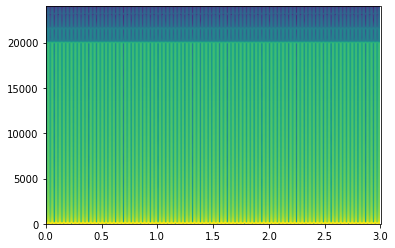

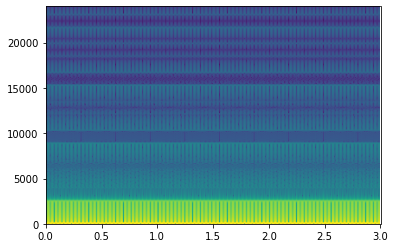

In [538]:
###### TEST CONSTANT FREQUENCY ######
test_dict = {
    'waveshape': cvsim.const_inp(WAVE_SQR),
    'mode': cvsim.const_inp(0),
    'coarse_adj': cvsim.const_inp(0.0025), # 50 Hz
    'fine_adj': cvsim.const_inp(0),
    'vpo': cvsim.const_inp(0),
    'fm_exp': cvsim.const_inp(0),
}
pb.play(wavetable, test_dict, plot=True);
pb.play(wavetable_poor, test_dict, plot=True);


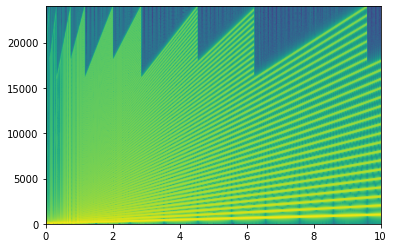

In [543]:
###### TEST FREQUENCY SWEEP ######
test_dict = {
    'waveshape': cvsim.const_inp(WAVE_SAW),
    'mode': cvsim.const_inp(0),
    'coarse_adj': cvsim.ramp_inp(0.0025, 0.050), # 50-1000 Hz
    'fine_adj': cvsim.const_inp(0),
    'vpo': cvsim.const_inp(0),
    'fm_exp': cvsim.const_inp(0),
}
wave = pb.play(wavetable, test_dict, plot=True, sg_fmin=0, sg_fmax=24000);

In [536]:
##### TEST 1 volt/octave AT CONSTANT COARSE FREQUENCY ######
test_dict = {
    'waveshape': cvsim.const_inp(WAVE_SIN),
    'mode': cvsim.const_inp(0),
    'coarse_adj': cvsim.const_inp(0.01),
    'fine_adj': cvsim.const_inp(0),
    'vpo': cvsim.sin_inp(1, 0.33), # sine w/ A=1, f=0.33Hz
    'fm_exp': cvsim.const_inp(0),
}
pb.play(wavetable, test_dict, plot=False)

array([0.        , 0.02617692, 0.05233672, ..., 0.72336503, 0.74044164,
       0.75705385])

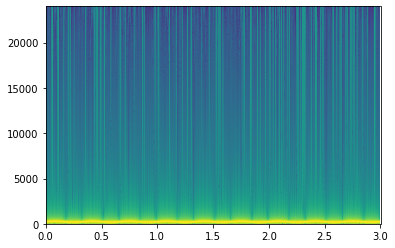

In [485]:
##### TEST FREQUENCY MODULATION ON CONSTANT PITCH #####
test_dict = {
    'waveshape': cvsim.const_inp(WAVE_SIN),
    'mode': cvsim.const_inp(0),
    'coarse_adj': cvsim.const_inp(0.01),
    'fine_adj': cvsim.const_inp(0),
    'vpo': cvsim.const_inp(0),
    'fm_exp': cvsim.sin_inp(A=0.3, f=3),
}
pb.play(wavetable, test_dict, plot=True);

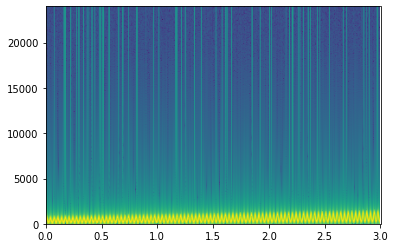

In [486]:
##### TEST FREQUENCY MODULATION ON RAMPING PITCH #####
test_dict = {
    'waveshape': cvsim.const_inp(WAVE_SIN),
    'mode': cvsim.const_inp(0),
    'coarse_adj': cvsim.ramp_inp(0.015, 0.030),
    'fine_adj': cvsim.const_inp(0),
    'vpo': cvsim.const_inp(0),
    'fm_exp': cvsim.sin_inp(A=1, f=30),
}
pb.play(wavetable, test_dict, plot=True);

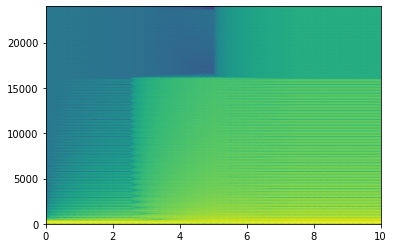

In [544]:
### TEST WAVE SHAPE MORPHING ###
test_dict = {
    'waveshape': cvsim.ramp_inp(0, NUM_WAVES),
    'mode': cvsim.const_inp(0),
    'coarse_adj': cvsim.const_inp(0.008),
    'fine_adj': cvsim.const_inp(0),
    'vpo': cvsim.const_inp(0),
    'fm_exp': cvsim.const_inp(0),
}
pb.play(wavetable, test_dict, plot=True);